In [1]:
!pip install kaggle #installing the kaggle API
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)
#copying the .json file to the required directory
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

Download 100%.


In [2]:
!kaggle datasets download -d stackoverflow/stacksample -p ./data

 99% 1.13G/1.15G [00:16<00:00, 42.7MB/s]
100% 1.15G/1.15G [00:16<00:00, 76.1MB/s]


In [3]:
!unzip ./data/stacksample.zip

Archive:  ./data/stacksample.zip
  inflating: Answers.csv             
  inflating: Questions.csv           
  inflating: Tags.csv                


In [0]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tqdm import tqdm

In [5]:
ques = pd.read_csv("Questions.csv",encoding="ISO-8859-1")
ques.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [6]:
ques.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
Id              1264216 non-null int64
OwnerUserId     1249762 non-null float64
CreationDate    1264216 non-null object
ClosedDate      55959 non-null object
Score           1264216 non-null int64
Title           1264216 non-null object
Body            1264216 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [7]:
tags = pd.read_csv("Tags.csv",encoding='ISO-8859-1')
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [8]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
Id     int64
Tag    object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [9]:
tags['Tag'] = tags['Tag'].astype(str)
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
5,330,c++ oop class nested-class
6,470,.net web-services
7,580,sql-server sql-server-2005 deployment release-...
8,650,c# visual-studio versioning
9,810,windows visual-studio registry installation


In [10]:
grouped_tags.head()

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [0]:
ques.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)
ques = ques.merge(grouped_tags, on='Id')

In [12]:
ques.head()

,Id,Score,Title,Body,Tag
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [0]:
ques = ques[ques['Score']>5]

In [14]:
ques.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72950 entries, 0 to 1264205
Data columns (total 5 columns):
Id       72950 non-null int64
Score    72950 non-null int64
Title    72950 non-null object
Body     72950 non-null object
Tag      72950 non-null object
dtypes: int64(2), object(3)
memory usage: 3.3+ MB


In [15]:
ques.drop(columns = ['Id','Score'],inplace=True)
ques.head()

,Title,Body,Tag
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [0]:
del tags
del grouped_tags

In [0]:
ques['Tag'] = ques['Tag'].apply(lambda x: x.split())
all_tags = [item for sublist in ques['Tag'].values for item in sublist]

In [18]:
len(all_tags)

224129

In [0]:
unique_tags = list(set(all_tags))

In [20]:
len(unique_tags)

14883

In [21]:
from collections import Counter
ques.head()

,Title,Body,Tag
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]"


In [0]:
counter = Counter(all_tags)
most_occur = counter.most_common(100)

In [23]:
tags = [i[0] for i in most_occur]
count = [i[1] for i in most_occur]
tags[:5],count[:5]

(['c#', 'java', 'javascript', 'android', 'python'],
 [6907, 6862, 5560, 5052, 4442])

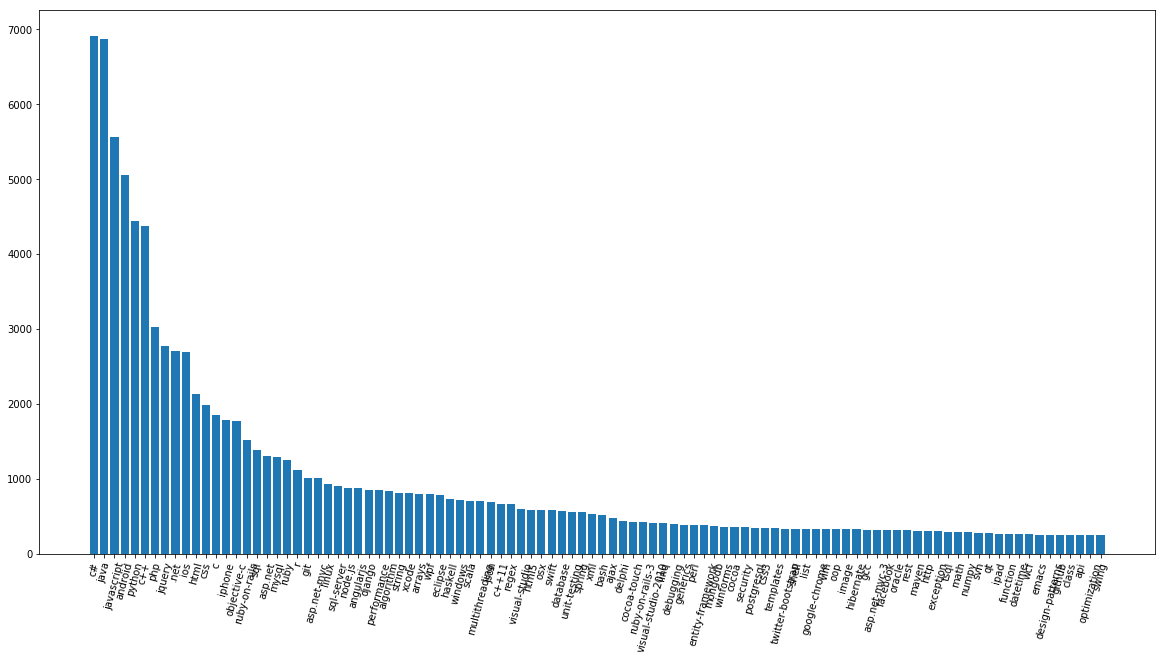

In [24]:
from matplotlib import pyplot as plt
x = np.arange(len(most_occur))
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x, height= count) 
plt.xticks(x, tags, rotation=75)
plt.show()

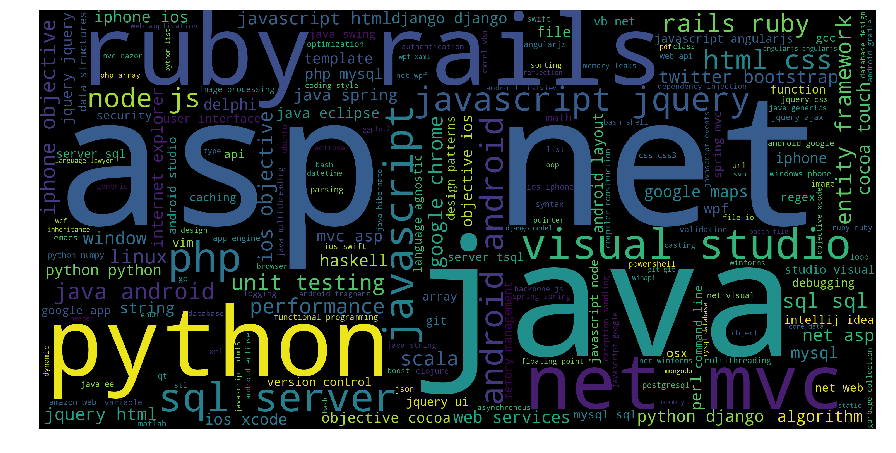

In [25]:
from wordcloud import WordCloud
def generate_wordcloud(text):
    wordcloud = WordCloud(width=3000,height = 1500).generate(text)
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

generate_wordcloud(" ".join(all_tags))

In [0]:
def most_common(x):
    tags_filtered = []
    for i in range(0, len(x)):
        if x[i] in tags:
            tags_filtered.append(x[i])
    return tags_filtered

In [0]:
ques['Tag'] = ques['Tag'].apply(lambda x: most_common(x))
ques['Tag'] = ques['Tag'].apply(lambda x: x if len(x)>0 else None)

In [28]:
ques.shape

(72950, 3)

In [29]:
ques.dropna(subset=['Tag'], inplace=True)
ques.shape

(63167, 3)

In [30]:
ques.head()

,Title,Body,Tag
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
5,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class]"


In [0]:
# Converting html to text in the body
ques['Body'] = ques['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [32]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [0]:
token=ToktokTokenizer()
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

def clean_text(text):
  text = text.lower()
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"\'s", " ", text)
  text = re.sub(r"\'ve", " have ", text)
  text = re.sub(r"can't", "can not ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r"\'scuse", " excuse ", text)
  text = re.sub(r"\'\n", " ", text)
  text = re.sub(r"\'\xa0", " ", text)
  text = re.sub('\s+', ' ', text)
  text = text.strip(' ')
  return text

def strip_list_noempty(mylist):
  newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
  return [item for item in newlist if item != '']

def clean_punct(text): 
  words=token.tokenize(text)
  punctuation_filtered = []
  regex = re.compile('[%s]' % re.escape(punct))
  remove_punctuation = str.maketrans(' ', ' ', punct)
  for w in words:
      if w in tags:
          punctuation_filtered.append(w)
      else:
          punctuation_filtered.append(regex.sub('', w))

  filtered_list = strip_list_noempty(punctuation_filtered)

  return ' '.join(map(str, filtered_list))

lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [0]:
def combine(new_df):
  new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x))
  print(1)
  new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x))
  print(2)
  new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
  print(3)
  new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x))
  print(4)
  new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
  print(5)
  new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
  print(6)
  new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x)) 
  print(7)
  new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
  print(8)
  new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x))
  return new_df

In [35]:
ques = combine(ques)
ques.head()

1
2
3
4
5
6
7
8


,Title,Body,Tag
1,good branch merge tutorials tortoisesvn,really good tutorials explain branch merge apa...,[svn]
2,asp.net site map,anyone get experience create sql-based asp.net...,"[sql, asp.net]"
3,function create color wheel,something pseudo-solved many time never quite ...,[algorithm]
4,add script functionality .net applications,little game write c use database back-end trad...,"[c#, .net]"
5,use nest class case,work collection class use video playback recor...,"[c++, oop, class]"


In [36]:
y = ques['Tag']
ques = ques.values
X = []

for i in tqdm(ques):
  X.append(i[0]+' '+i[1])

100%|██████████| 63167/63167 [00:00<00:00, 633245.30it/s]


In [0]:
# X = np.array(X)

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()
Y = multilabel_binarizer.fit_transform(y)

In [39]:
len(X),Y.shape

(63167, (63167, 100))

In [40]:
X[0]

'good branch merge tutorials tortoisesvn really good tutorials explain branch merge apache subversion better specific tortoisesvn client'

In [0]:
import pickle
with open('X.pkl','wb') as f:
  pickle.dump(X, f)
with open('Y.pkl','wb') as f:
  pickle.dump(Y, f)

In [0]:
from google.colab import files
files.download('X.pkl')
files.download('Y.pkl')